**Kaggle**

Arrhythmia Dataset
Number of Samples: 109446  
Number of Categories: 5  
Sampling Frequency: 125Hz  
**Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]**   
Data Source: Physionet's MIT-BIH Arrhythmia Dataset  

The PTB Diagnostic ECG Database  
Number of Samples: 14552  
Number of Categories: 2  
**Classes: ['0': N (Normal), '1': ['S', 'V', 'F', 'Q'] (Abnormal)]**      
Sampling Frequency: 125Hz  
Data Source: Physionet's PTB Diagnostic Database

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.  

In [1]:
# from google.colab import files
# files.upload()   # Upload your kaggle.json here

# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d shayanfazeli/heartbeat

# !unzip heartbeat.zip -d ecg_data

**Lets Begin**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

from utils.data import *

In [3]:
mitbih_train_val_df = pd.read_csv("data/mitbih_train.csv", header=None)
mitbih_test_df = pd.read_csv("data/mitbih_test.csv", header=None)
print(f"MitBih (Train + Val) Df shape: {mitbih_train_val_df.shape}")
print(f"MitBih Test Df shape: {mitbih_test_df.shape}")

print("-----------------------------------------")

ptb_normal_df = pd.read_csv("data/ptbdb_normal.csv", header=None)
ptb_abnormal_df = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
print(f"Ptb Normal Df shape: {ptb_normal_df.shape}")
print(f"Ptb AbNormal Df shape: {ptb_abnormal_df.shape}")


MitBih (Train + Val) Df shape: (87554, 188)
MitBih Test Df shape: (21892, 188)
-----------------------------------------
Ptb Normal Df shape: (4046, 188)
Ptb AbNormal Df shape: (10506, 188)


In [4]:
class_map = {
    "0": "N", 
    "1": "S",
    "2": "V",
    "3": "F",
    "4": "Q"
}

In the MIT Dataset we have distinct Classes  
Class 1: N --> Normal Beat   
Class 2: S --> Supraventricular Ectopy  
Class 3: V --> Ventricular Ectopy  
Class 4: F --> Fusion Beat  
Class 5: Q --> Unknown Beat  
      
However the PTB Dataset is a bit more ambiguous. 
Class 0 (Normal) will remain as it is. Class 0 (N)  
Class 1 (Abnormal) will be mapped to Class 4 (Q: Unknown)

In [5]:
# Mapping Classes Accordingly
ptb_normal_df.iloc[:, -1] = 0
ptb_abnormal_df.iloc[:, -1] = 4

-- Now we combine all the Datasets (MIT + PTB)

In [6]:
# combine ptb datasets
ptb_combined_df = pd.concat([ptb_normal_df, ptb_abnormal_df], ignore_index=True, axis=0)
print(f"Ptb Combined Df shape: {ptb_combined_df.shape}")

print("-------------------------------------------")

# combine ptb and mit datasets 
# this will form the new (Train + Val) dataset
combined_train_val_df = pd.concat([mitbih_train_val_df, ptb_combined_df], ignore_index=True, axis=0)
print(f"Combined Df (Train + Val) shape: {combined_train_val_df.shape}")

Ptb Combined Df shape: (14552, 188)
-------------------------------------------
Combined Df (Train + Val) shape: (102106, 188)


In [7]:
combined_train_val_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-- Separate Features (X) and Labels (y)

In [8]:
X, y = split_x_y(mitbih_train_val_df) # (Train + Val)
X_test, y_test = split_x_y(mitbih_test_df) # (Test)

-- Plot Class Distribution

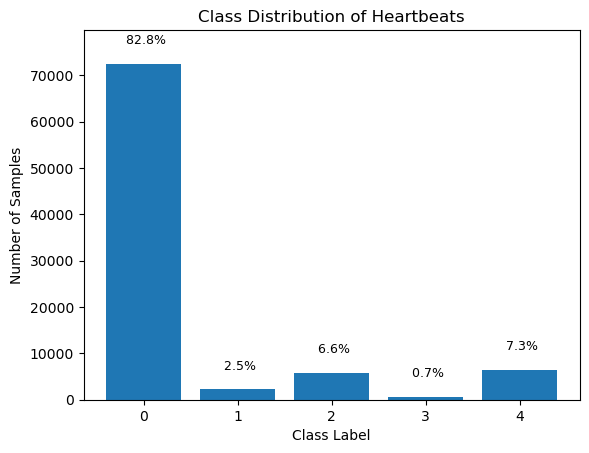

In [9]:
plot_class_distributions(y=y, 
                         title="Class Distribution of Heartbeats",
                         xlabel="Class Label",
                         ylabel="Number of Samples",)

-- Creating our Train Val Split  

We notice that there is a significant imbalance in classes  
Hence we will use a stratified split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X,y,
    test_size= 0.2,
    random_state= 42,
    stratify= y # ensures equal class representation
)

-- Plotting Samples from each Class before Normalisation

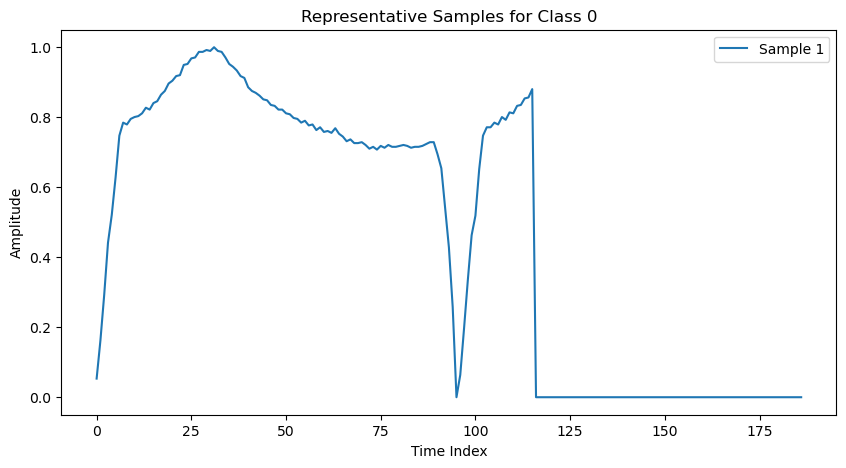

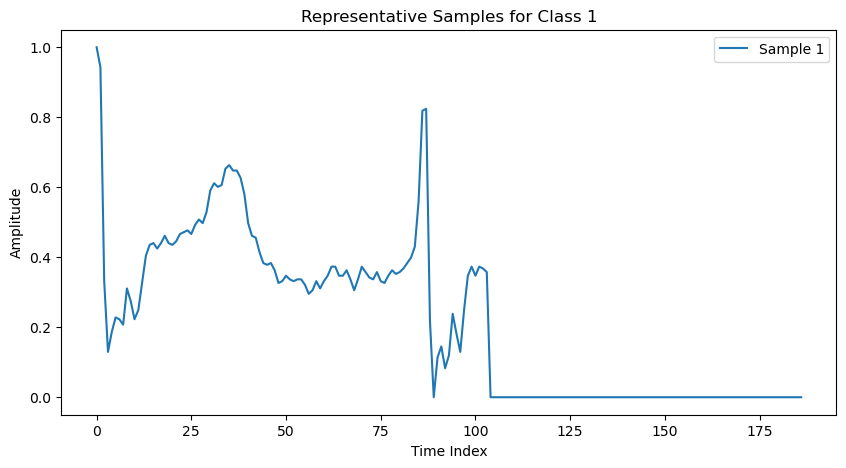

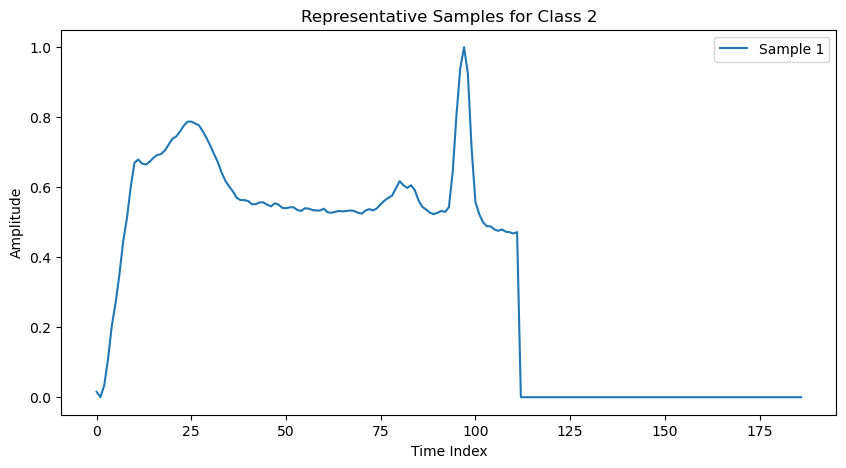

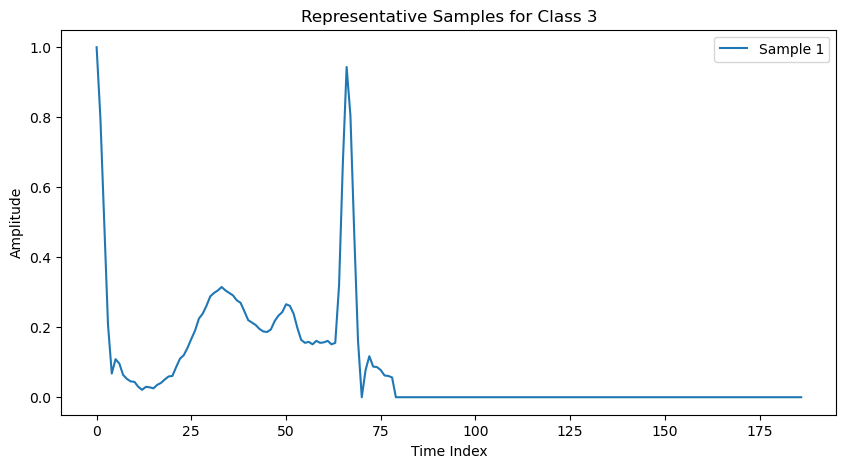

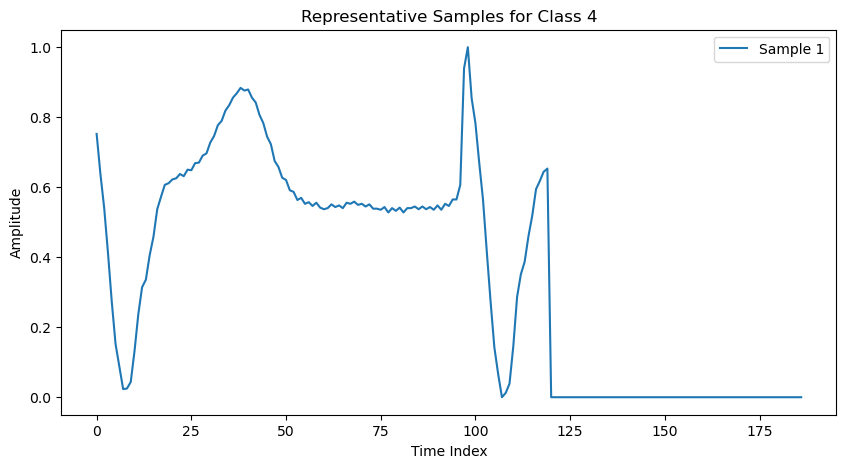

In [11]:
plot_unique_class_samples(X_train,y_train,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(10,5))

**Data Preprocessing**

In [12]:
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm

from utils.data import sample

c:\Users\William\miniconda3\envs\neural_networks\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
X_train_preprocessed = np.copy(X_train)

-- Denoising using a Low-Pass Filter  
  
  Reason: Removes muscle artifact and smoothing.

In [14]:
from utils.preprocessing import apply_low_pass_filter

In [15]:
for i in tqdm(range(X_train.shape[0]), desc="Applying Low Pass Filter", leave=False):

    X_sample = X_train[i]

    X_train_preprocessed[i] = apply_low_pass_filter(sample=X_sample,
                          sampling_frequency=125,
                          cutoff_frequency=20)
    

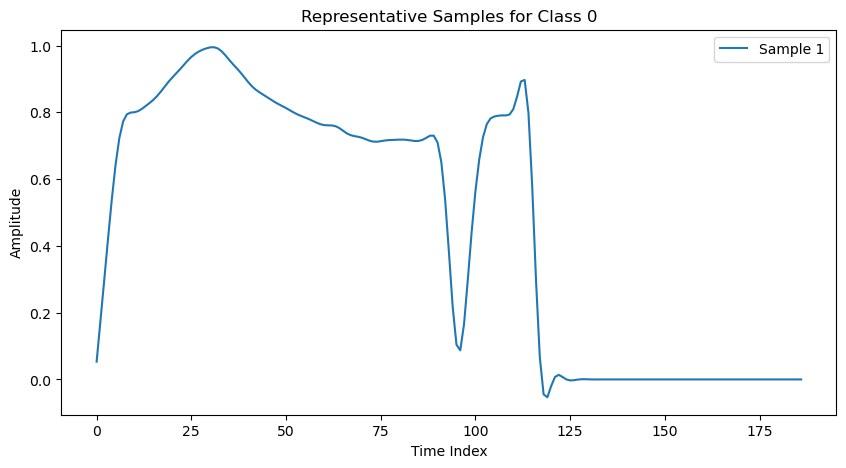

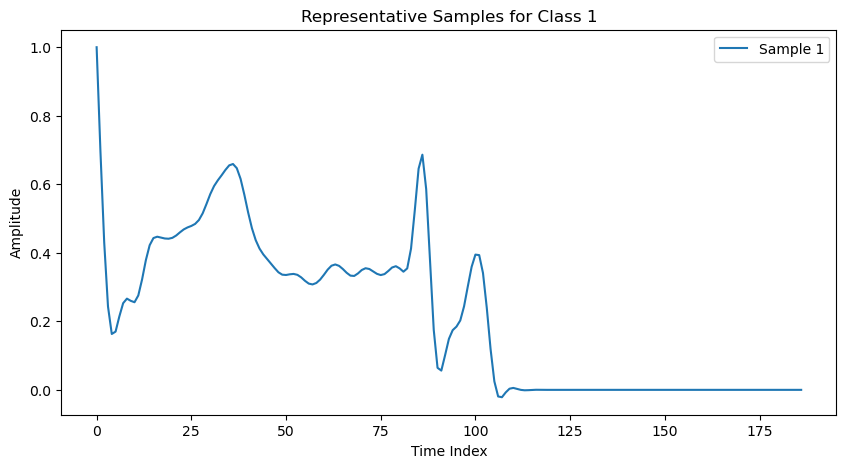

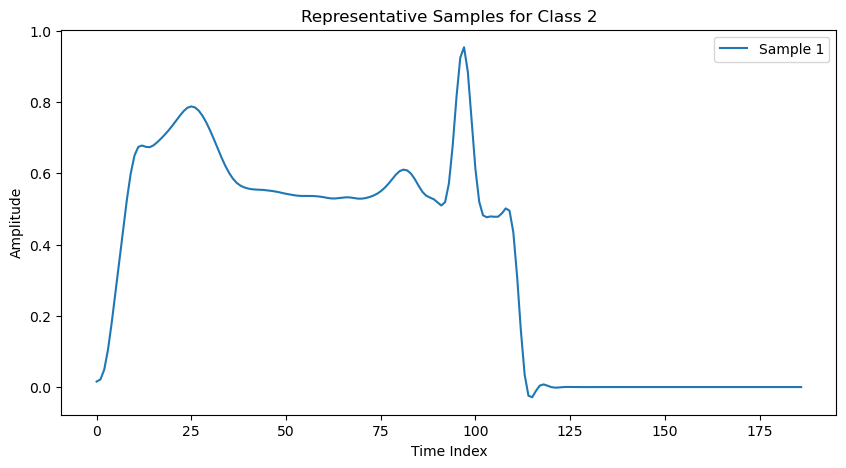

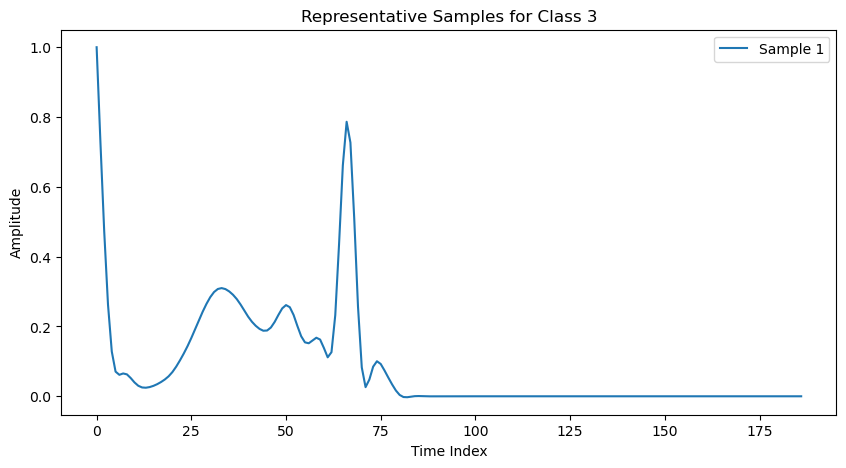

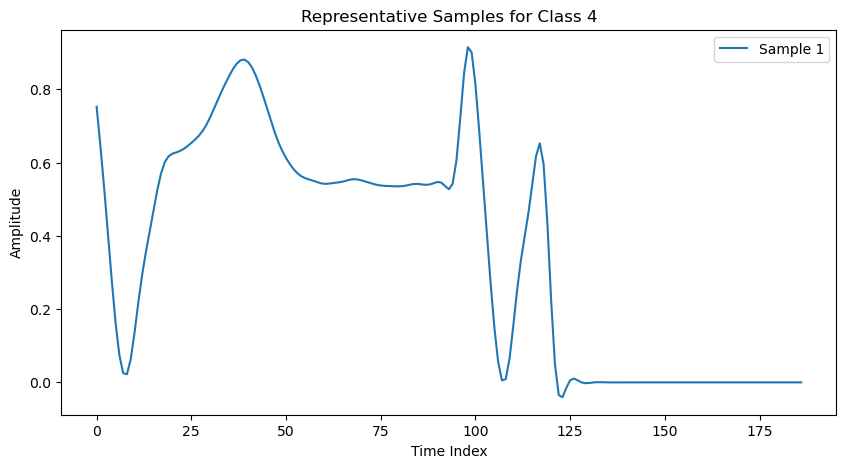

In [16]:
plot_unique_class_samples(X_train_preprocessed,y_train,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(10,5))

-- Detecting R-Peaks

In [17]:
from utils.preprocessing import get_r_peak_locations

In [18]:
# We just need a small sample because it will result in a mean close enough to the actual mean
X_train_sample = sample(X_train, sample_size_fraction= 0.01, random_state= 42)

print(f"Sampling {len(X_train_sample)} of {len(X_train)} samples")
print("--------------------------------------------")

r_peak_indices = get_r_peak_locations(X=X_train_sample, sampling_rate=125)

print(f"Mean R_Peak Index: {np.round(np.mean(r_peak_indices).item())}")

Sampling 700 of 70043 samples
--------------------------------------------


Mean R_Peak Index: 41.0


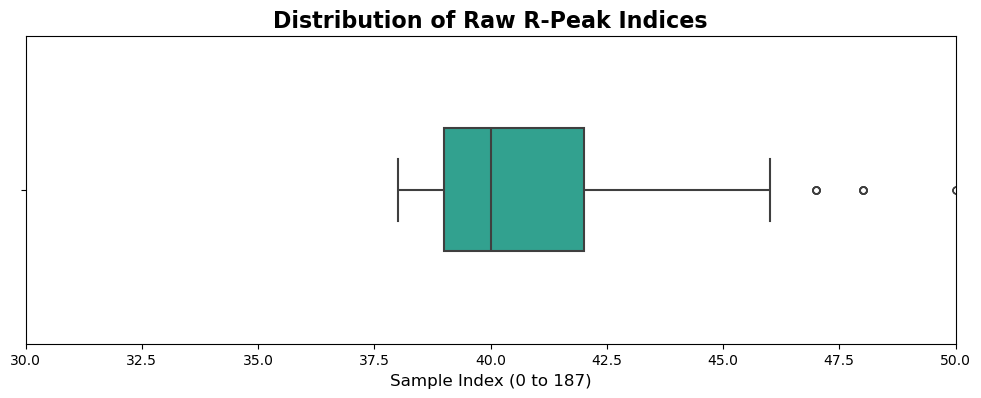

In [19]:
LOWER_LIMIT = 30
UPPER_LIMIT = 50 

plt.figure(figsize=(12, 4)) 

sns.boxplot(
    x=r_peak_indices, 
    color="#1fb49b", 
    width=0.4,        
    linewidth=1.5,     
    fliersize=5        
)

plt.xlim(LOWER_LIMIT, UPPER_LIMIT)

plt.title('Distribution of Raw R-Peak Indices', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index (0 to 187)', fontsize=12)

plt.show()

It looks like the raw data is biased to have a peak around index 41  

However for this experiment we will be **shifing the R-peaks to Index 94 (187 / 2)**
  
Reason:  
  1) The primary reason for shifting the R-peaks from the observed raw mean of $\approx 41$ to the symmetrical center of Index 94 is to achieve optimal temporal symmetry for deep learning model stability and feature extraction.

  2) Maximizing Informative Features:   
    Initially we had 41 sequence samples consisting of P,Q waves (Before R). and 147 sequence samples consisting of the S,T waves (After R) and padded 0s. As you can see, the model has less time steps(for RNNs) / less samples to learn about P,Q waves (41 time steps).  

    By shifting the R to 94, we have more balanced feature set (94 samples before and 93 samples after), and so the model has more context (time steps / samples) to learn the pattern of both the P Q and S, T waves effectively, leading to a faster convergence and higher accuracy 

 

In [20]:
pd.DataFrame(X_train_preprocessed).head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.053199,0.173960,0.296767,0.420109,0.538437,0.642952,0.723266,0.772706,0.794235,0.799339,...,1.284748e-13,-6.316087e-14,-9.979435e-14,-4.953604e-14,3.219944e-15,2.255323e-14,1.568646e-14,2.656838e-15,-4.371513e-15,-4.373751e-15
1,0.974258,0.780896,0.567039,0.345042,0.155981,0.036651,-0.006591,0.002672,0.030372,0.051896,...,4.420415e-04,-9.616742e-06,-1.865818e-04,-1.366106e-04,-2.710889e-05,3.508501e-05,3.745442e-05,1.396868e-05,-4.691929e-06,-9.211354e-06
2,0.752383,0.644604,0.529320,0.404731,0.277872,0.162659,0.074406,0.025344,0.022183,0.063112,...,-1.054209e-12,-1.470080e-13,3.175572e-13,2.990217e-13,9.629814e-14,-4.893056e-14,-7.599781e-14,-3.738656e-14,2.706260e-15,1.723016e-14
3,0.977646,0.795251,0.612850,0.450022,0.332371,0.265459,0.231881,0.209161,0.184197,0.154734,...,2.682995e-15,-3.922900e-15,-4.046173e-15,-1.455039e-15,5.475646e-16,1.003804e-15,5.339262e-16,-5.517981e-18,-2.210972e-16,-1.643697e-16
4,0.015469,0.021319,0.048639,0.104852,0.182232,0.268437,0.356145,0.443325,0.527102,0.599450,...,1.981277e-15,1.217450e-14,8.368929e-15,1.359711e-15,-2.375766e-15,-2.342691e-15,-8.000171e-16,3.490068e-16,5.880458e-16,3.013249e-16


-- R-Peak Alignment and Centering

In [21]:
from utils.preprocessing import linear_alignment_of_r_peak

In [22]:
for i in tqdm(range(X_train_preprocessed.shape[0]), leave=False, desc="Performing Linear Alignment"):

    X_sample = X_train_preprocessed[i]

    X_train_preprocessed[i] = linear_alignment_of_r_peak(sample=X_sample,
                                      sampling_rate=125,
                                      target_index=94,
                                      method="pantompkins")

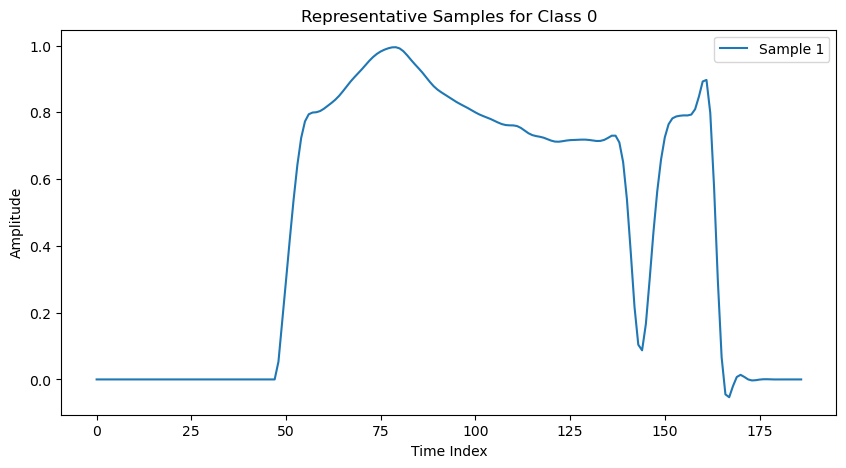

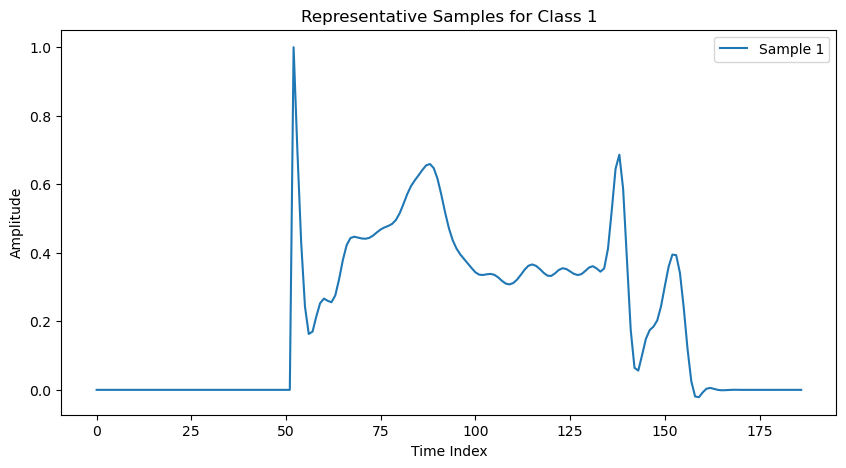

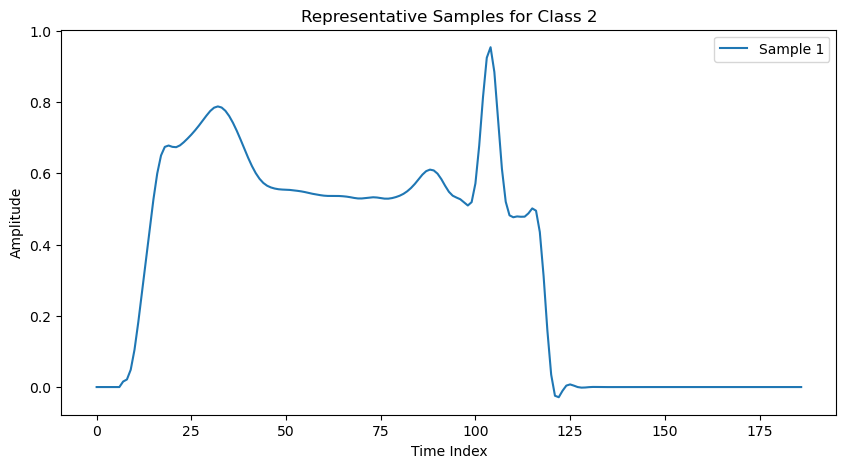

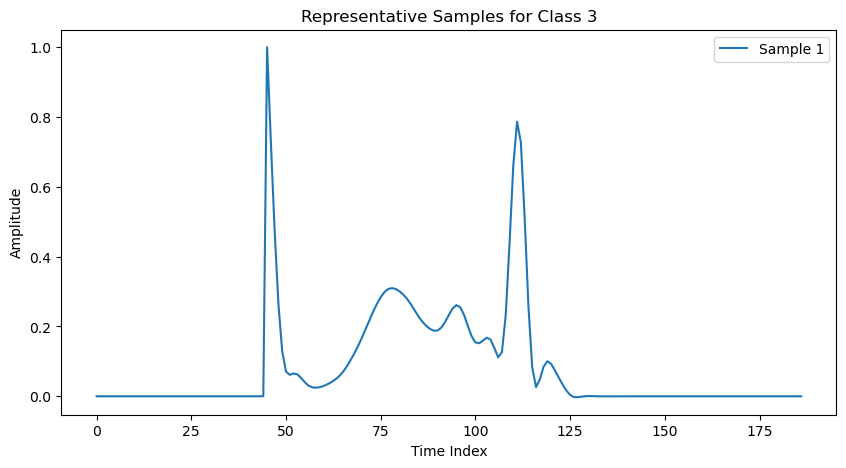

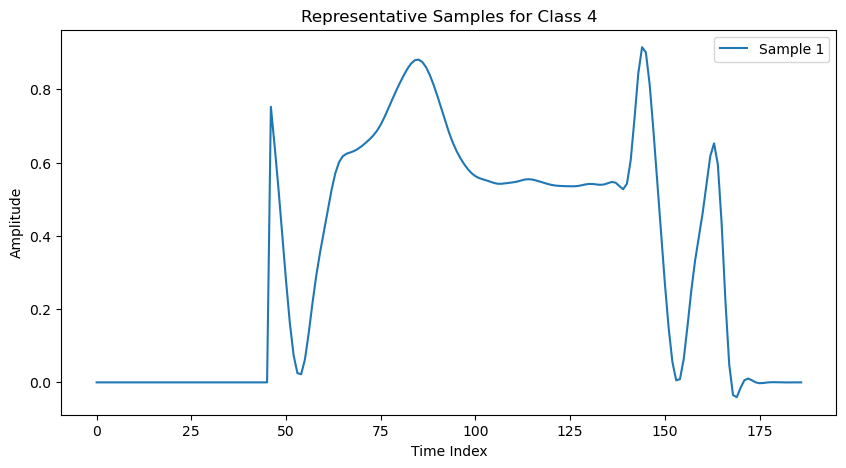

In [23]:
plot_unique_class_samples(X_train_preprocessed,y_train,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(10,5))

-- Normalizng Z-Score

This process ensures that every single heartbeat is presented to the neural network with a consistent, standard amplitude range ($\text{std} \approx 1$), forcing the network to focus on the morphology and timing, not the absolute amplitude

In [24]:
from utils.preprocessing import z_score_normalization

In [25]:
X_train_preprocessed = z_score_normalization(X_train_preprocessed)

In [26]:
pd.DataFrame(X_train_preprocessed).head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,-1.183991,-1.183991,-1.183991,-1.183991,-1.183991,-1.183991,-1.183991,-1.183991,-1.183991,-1.183991,...,-1.182427,-1.183382,-1.184168,-1.184372,-1.184206,-1.183999,-1.183910,-1.183927,-1.183976,-1.184006
1,-0.736023,-0.736023,-0.736023,-0.736023,-0.736023,-0.736023,-0.736023,-0.736023,-0.736023,-0.736023,...,0.400772,0.450191,0.515348,0.853939,1.723894,3.077965,4.440116,5.149857,4.799407,3.504716
2,-1.133424,-1.133424,-1.133424,-1.133424,-1.133424,-1.133424,-1.133424,-1.133424,-1.133424,-1.133424,...,-1.134599,-1.132058,-1.131917,-1.132844,-1.133599,-1.133792,-1.133630,-1.133430,-1.133345,-1.133362
3,-0.638455,-0.638455,-0.638455,-0.638455,-0.638455,-0.638455,-0.638455,-0.638455,-0.638455,-0.638455,...,-0.639268,-0.638926,-0.638479,-0.638282,-0.638315,-0.638420,-0.638485,-0.638492,-0.638471,-0.638452
4,-1.128196,-1.128196,-1.128196,-1.128196,-1.128196,-1.128196,-1.128196,-1.077011,-1.057655,-0.967257,...,-1.128196,-1.128196,-1.128196,-1.128196,-1.128196,-1.128196,-1.128196,-1.128196,-1.128196,-1.128196


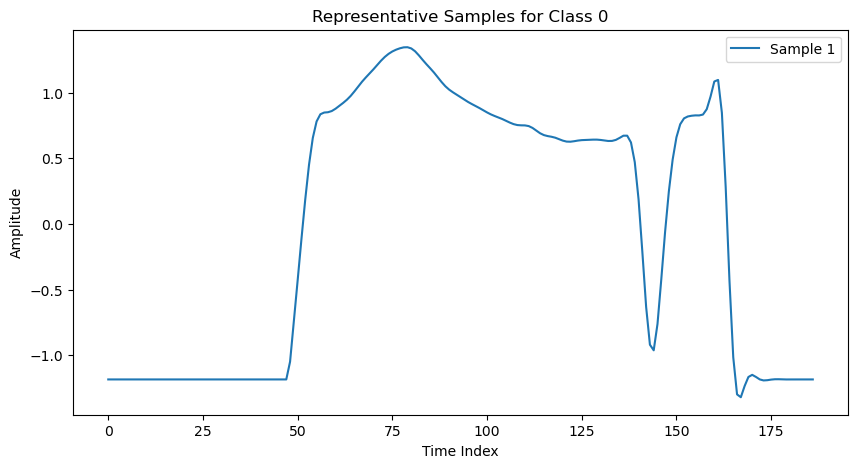

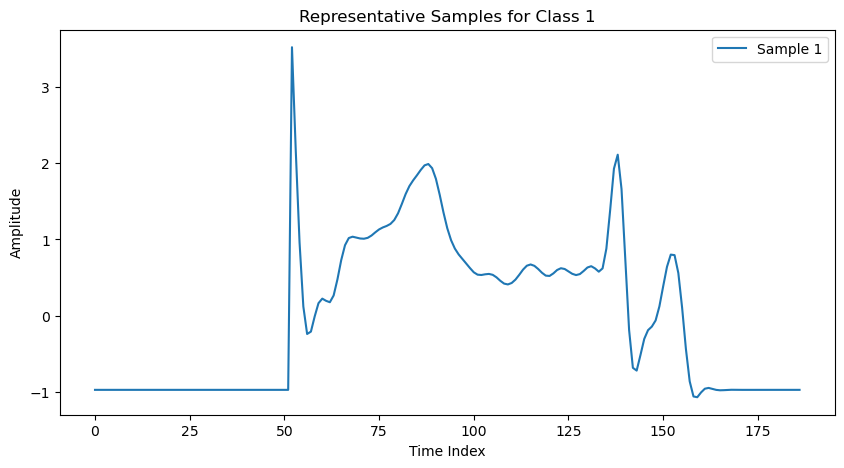

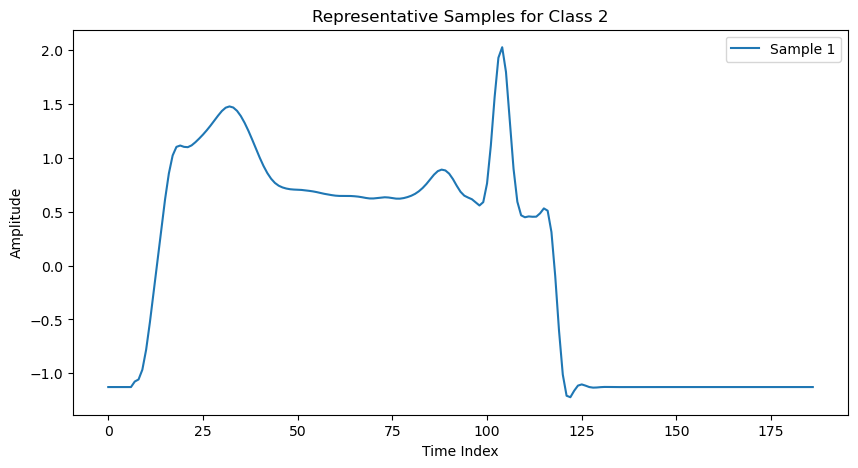

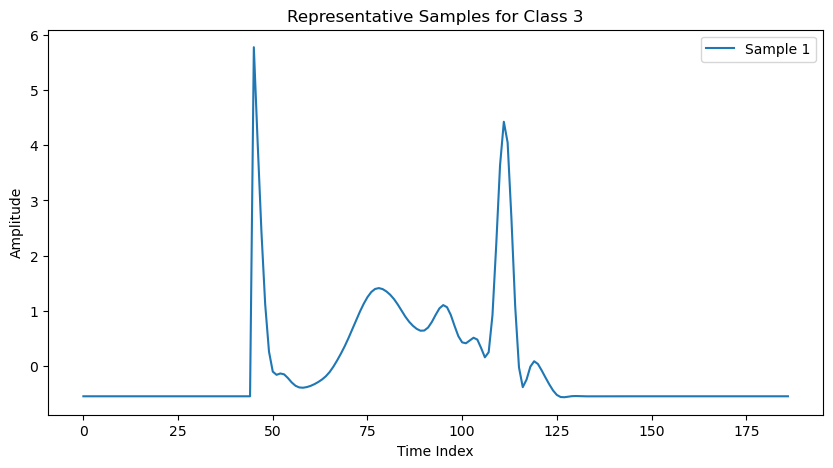

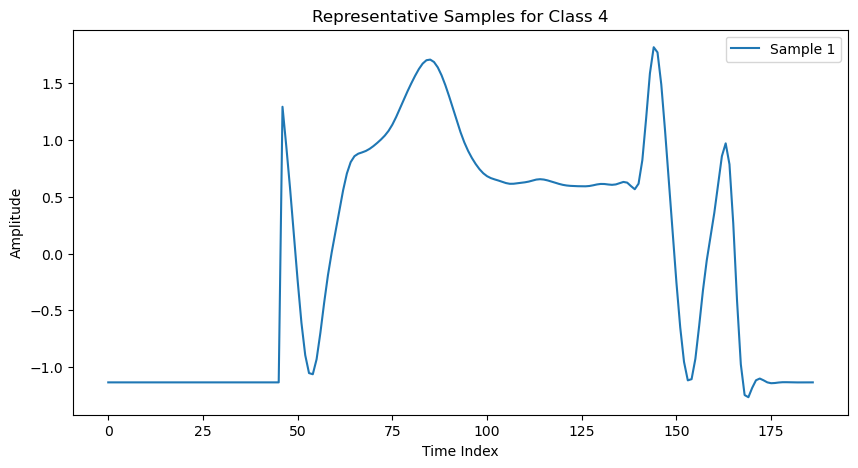

In [27]:
plot_unique_class_samples(X_train_preprocessed,y_train,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(10,5))

**Class Imbalance Analysis and Weight Calculation**  
  
We saw how the classes were imbalanced  
Hence for the training we will calculate class weights for each label.  
  
We will make use of a Random Weighted Sampler and use it in our dataloaders  
  
We used the inverse frequency of each class to compute the weights. Rarers classes would hence have higher weightage and would be sampled more often

In [28]:
import torch
from torch.utils.data import WeightedRandomSampler
from utils.data import calculate_class_weights

In [29]:
labels, class_weights = calculate_class_weights(y_train)

print("------------The Class Weights are as follows ----------\n")
for (label, weight) in zip(labels, class_weights):
    print(f"Class {label}: {weight}")

# assign the weights to all of y_train
train_sample_weights = np.array(class_weights)[y_train]

------------The Class Weights are as follows ----------

Class 0: 1.724821912137572e-05
Class 1: 0.0005624296962879641
Class 2: 0.00021598272138228941
Class 3: 0.001949317738791423
Class 4: 0.00019436345966958212


In [30]:
train_sample_weights = torch.from_numpy(train_sample_weights).float()

weighted_sampler = WeightedRandomSampler(
    weights= train_sample_weights,
    num_samples= len(train_sample_weights),
    replacement=True,
)

**Creating our Final Train, Val and Test DataFrames**

In [31]:
from utils.preprocessing import Preprocessing

In [ ]:
preprocesser = Preprocessing(
    sample_freq= 125,
    cutoff_freq= 25,
    target_r_peak_index= 94,
    method="pantompkins"
)

# We've already Preprocessed the Train Set

# Preprocess Val Set
print("---------------Preprocessing Validation Data-------------")
X_val_preprocessed = preprocesser.transform(X_val)

print("\n--------------------------\n")


# Preprocess Test Set
print("---------------Preprocessing Test Data-------------------")
X_test_preprocessed = preprocesser.transform(X_test)

# Creating Train, Val and Test
train_df = pd.DataFrame(np.column_stack((X_train_preprocessed, y_train)))
val_df   = pd.DataFrame(np.column_stack((X_val_preprocessed, y_val)))
test_df   = pd.DataFrame(np.column_stack((X_test_preprocessed, y_test)))

Preprocessing Validation Data
Applying Low-Pass Filter ...


Perforing R-Peak Realignment ... 


Performing Z-Score Normalization for Each Sample ...

--------------------------

Preprocessing Test Data
Applying Low-Pass Filter ...


Perforing R-Peak Realignment ... 


Performing Z-Score Normalization for Each Sample ...


**TRAINING**

In [33]:
from utils.torch_classes import ECG_Dataset

**RNNS**

In [34]:
from utils.rnn_models import ECG_BiLSTM_Classifier

-- HYPERPARAM GRID

In [38]:
# HyperParams
BATCH_SIZE = 128
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT = 0.3

PATIENCE = 10
DELTA = 0.001

-- LSTM

In [36]:
# Creating Datasets
train_dataset = ECG_Dataset(train_df)
val_dataset = ECG_Dataset(val_df)
test_dataset = ECG_Dataset(test_df)

# Creating DataLoaders
train_dataloader = DataLoader(
    dataset= train_dataset,
    batch_size= BATCH_SIZE,
    shuffle= False, 
    sampler=sampler
)

val_dataloader = DataLoader(
    dataset= val_dataset,
    batch_size= BATCH_SIZE,
    shuffle= False, 
)

test_dataloader = DataLoader(
    dataset= test_dataset,
    batch_size= BATCH_SIZE,
    shuffle= False, 
)

# testing the data loader
batch = next(iter(train_dataloader))
y = batch["y"]
for label, count in zip(np.unique(y), np.bincount(y)):
    print(f"Class {label}: {count}")


NameError: name 'DataLoader' is not defined